In [1]:
# My solution is not working so I'm testing the solution from learn.co to compare results

In [2]:
# Your code here; load and preview the dataset
import pandas as pd

data = pd.read_csv("loan_final.csv", header=0)

# drop rows with no label
data.dropna(subset=['total_pymnt'],inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42535 entries, 0 to 42537
Data columns (total 16 columns):
loan_amnt              42535 non-null float64
funded_amnt_inv        42535 non-null float64
term                   42535 non-null object
int_rate               42535 non-null object
installment            42535 non-null float64
grade                  42535 non-null object
emp_length             41423 non-null object
home_ownership         42535 non-null object
annual_inc             42531 non-null float64
verification_status    42535 non-null object
loan_status            42535 non-null object
purpose                42535 non-null object
addr_state             42535 non-null object
total_acc              42506 non-null float64
total_pymnt            42535 non-null float64
application_type       42535 non-null object
dtypes: float64(6), object(10)
memory usage: 5.5+ MB


In [3]:
import numpy as np

features = ['loan_amnt', 'funded_amnt_inv', 'installment', 'annual_inc', 'home_ownership', 'verification_status', 'emp_length']

X = data.loc[:, features]
y = data.loc[:, 'total_pymnt']

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31901 entries, 41522 to 15725
Data columns (total 7 columns):
loan_amnt              31901 non-null float64
funded_amnt_inv        31901 non-null float64
installment            31901 non-null float64
annual_inc             31897 non-null float64
home_ownership         31901 non-null object
verification_status    31901 non-null object
emp_length             31108 non-null object
dtypes: float64(4), object(3)
memory usage: 1.9+ MB


In [5]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer


# Select continuous features
cont_features = ['loan_amnt', 'funded_amnt_inv', 'installment', 'annual_inc']
X_train_cont = X_train.loc[:, cont_features]

# Fill missing values with the mean
cont_imp = SimpleImputer(strategy='mean')
cont_imp.fit(X_train_cont)
X_train_cont = cont_imp.transform(X_train_cont)

# standardized inputs
sc = StandardScaler()
sc.fit(X_train_cont)
X_train_scaled = sc.transform(X_train_cont)

# Create continuous features dataframe
cont_train_df = pd.DataFrame(X_train_scaled, columns=cont_features)

# Select only the categorical features
cat_features = ['home_ownership', 'verification_status', 'emp_length']
X_train_cat = X_train.loc[:, cat_features]

# Replace NaNs with 'missing'
cat_imp = SimpleImputer(strategy='constant', fill_value='missing')
cat_imp.fit(X_train_cat)
X_train_cat = cat_imp.transform(X_train_cat)

# Encode Categorical Features
ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(X_train_cat)
X_train_ohe = ohe.transform(X_train_cat)

# Create categorical features dataframe
cat_train_df = pd.DataFrame(X_train_ohe.todense(), columns=ohe.get_feature_names(input_features=cat_features))

# Combine continuous and categorical feature dataframes
X_train_all = pd.concat([cont_train_df, cat_train_df], axis=1)

X_train_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31901 entries, 0 to 31900
Data columns (total 24 columns):
loan_amnt                              31901 non-null float64
funded_amnt_inv                        31901 non-null float64
installment                            31901 non-null float64
annual_inc                             31901 non-null float64
home_ownership_MORTGAGE                31901 non-null float64
home_ownership_NONE                    31901 non-null float64
home_ownership_OTHER                   31901 non-null float64
home_ownership_OWN                     31901 non-null float64
home_ownership_RENT                    31901 non-null float64
verification_status_Not Verified       31901 non-null float64
verification_status_Source Verified    31901 non-null float64
verification_status_Verified           31901 non-null float64
emp_length_1 year                      31901 non-null float64
emp_length_10+ years                   31901 non-null float64
emp_length_2 years     

In [6]:
X_test_cont = X_test.loc[:, cont_features]

# Fill missing values with the mean
X_test_cont = cont_imp.transform(X_test_cont)

# standardized inputs
X_test_scaled = sc.transform(X_test_cont)

# Create continuous features dataframe
cont_test_df = pd.DataFrame(X_test_scaled, columns=cont_features)

# Select only the categorical features
X_test_cat = X_test.loc[:, cat_features]

# Replace NaNs with 'missing'
X_test_cat = cat_imp.transform(X_test_cat)

# Encode Categorical Features
X_test_ohe = ohe.transform(X_test_cat)

# Create categorical features dataframe
cat_test_df = pd.DataFrame(X_test_ohe.todense(), columns=ohe.get_feature_names(input_features=cat_features))

# Combine continuous and categorical feature dataframes
X_test_all = pd.concat([cont_test_df, cat_test_df], axis=1)

X_test_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10634 entries, 0 to 10633
Data columns (total 24 columns):
loan_amnt                              10634 non-null float64
funded_amnt_inv                        10634 non-null float64
installment                            10634 non-null float64
annual_inc                             10634 non-null float64
home_ownership_MORTGAGE                10634 non-null float64
home_ownership_NONE                    10634 non-null float64
home_ownership_OTHER                   10634 non-null float64
home_ownership_OWN                     10634 non-null float64
home_ownership_RENT                    10634 non-null float64
verification_status_Not Verified       10634 non-null float64
verification_status_Source Verified    10634 non-null float64
verification_status_Verified           10634 non-null float64
emp_length_1 year                      10634 non-null float64
emp_length_10+ years                   10634 non-null float64
emp_length_2 years     

In [7]:
from sklearn.model_selection import KFold
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def k_folds(features_train, labels_train, model_obj, k=10, n_epochs=100):
    colors = sns.color_palette("Set2")

    validation_scores = []
    
    kf = KFold(n_splits=10, shuffle=True)
    
    fig, axes = plt.subplots(2, 5, figsize=(12,8))
    for i, (train_index, test_index) in enumerate(kf.split(features_train)):
        "Currently graph imaging assumes 10 folds and is hardcoded to 5x2 layout."
        
        row = i//5
        col = i%5
        
        X_train, X_val = features_train.iloc[train_index], features_train.iloc[test_index]
        y_train, y_val = labels_train.iloc[train_index], labels_train.iloc[test_index]
        
        model = model_obj
        
        hist = model.fit(X_train, y_train, batch_size=32,
                         epochs=n_epochs, verbose=0, validation_data = (X_val, y_val))
        #Note: verboxe=0 turns off printouts regarding training for each epoch.
        #Potential simpler methodology
        validation_score = model.evaluate(X_val, y_val)
        validation_scores.append(validation_score)
        ax = axes[row, col]
        k = 'val_loss'
        d = hist.history[k]
        ax.plot(d, label=k, color=colors[0])

        k = 'loss'
        d = hist.history[k]
        ax.plot(d, label=k, color=colors[1])
        ax.set_title('Fold {} Validation'.format(i+1))
        
    #Final Graph Formatting
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)
    plt.legend(bbox_to_anchor=(1,1))
    
    #General Overview
    validation_score = np.average(validation_scores)
    print('Mean Validation Score:', validation_score)
    print('Standard Deviation of Validation Scores:', np.std(validation_scores))
    return validation_score

In [8]:
from keras.models import Sequential
from keras.layers import Dense

input_dim = X_train_all.shape[1]

np.random.seed(123)
model = Sequential()
model.add(Dense(7, input_dim=input_dim, kernel_initializer='normal', activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, kernel_initializer='normal', activation = 'linear'))
model.compile(optimizer="sgd" ,loss='mse',metrics=['mse'])

Using TensorFlow backend.


3190/3190 [==============================] - 0s 128us/step
Mean Validation Score: 83307813.97071454
Standard Deviation of Validation Scores: 1972843.124214167
Time Elapsed: 0:41:38.621572


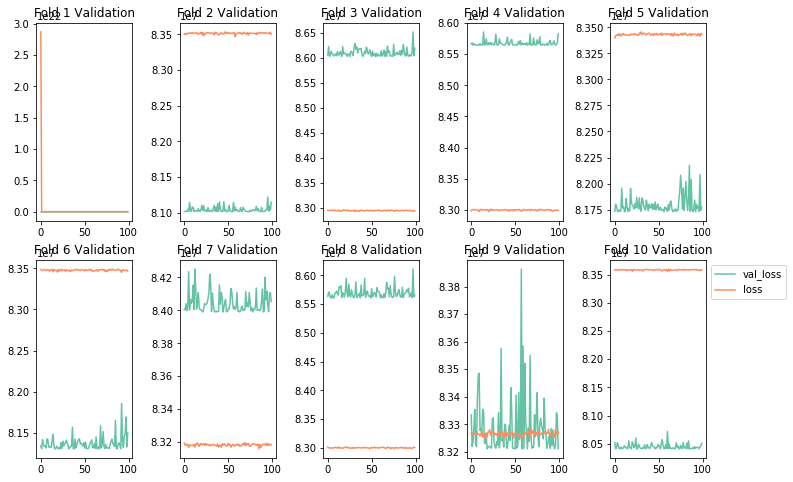

In [9]:
import time
import datetime

now = datetime.datetime.now()

k_folds(X_train_all, y_train, model)

later = datetime.datetime.now()
elapsed = later - now
print('Time Elapsed:', elapsed)

3190/3190 [==============================] - 0s 127us/step
Mean Validation Score: nan
Standard Deviation of Validation Scores: nan
Time Elapsed: 0:41:45.186629


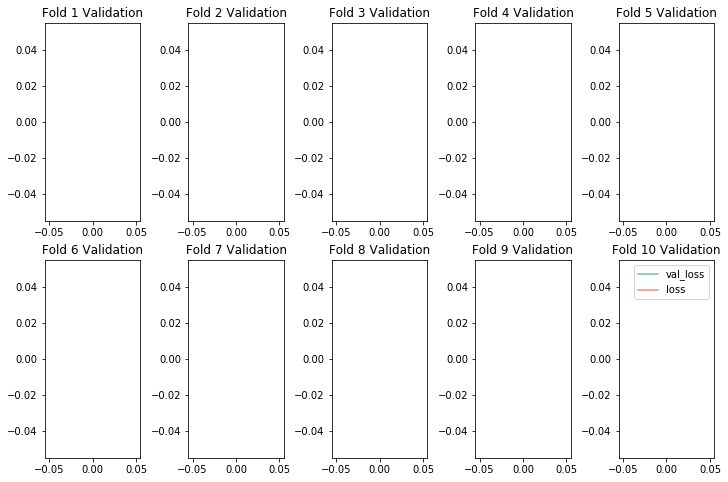

In [10]:
now = datetime.datetime.now()

input_dim = X_train_all.shape[1]

#Model Mod 1: Adding More Layers
model = Sequential()
model.add(Dense(7, input_dim=input_dim, kernel_initializer='normal', activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, kernel_initializer='normal', activation = 'linear'))
model.compile(optimizer="sgd" ,loss='mse',metrics=['mse'])

k_folds(X_train_all, y_train, model)    

later = datetime.datetime.now()
elapsed = later - now
print('Time Elapsed:', elapsed)

3190/3190 [==============================] - 0s 112us/step
Mean Validation Score: nan
Standard Deviation of Validation Scores: nan
Time Elapsed: 0:40:41.109019


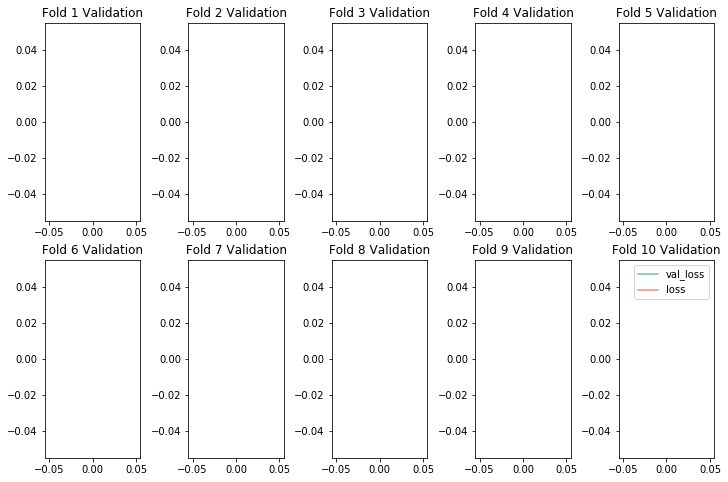

In [12]:
# Model Mod 2: More Layers and Bigger Layers
# Your code here
# Timing Notes: On a top of the line mac-book pro, using our 10 fold cross validation methodology,
# a 5-layer neural network with 25 units per hidden layer and 100 epochs took ~25 minutes to train and validate

now = datetime.datetime.now()

input_dim = X_train_all.shape[1]

model = Sequential()
model.add(Dense(7, input_dim=input_dim, kernel_initializer='normal', activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(1, kernel_initializer='normal', activation = 'linear'))
model.compile(optimizer="sgd" ,loss='mse',metrics=['mse'])

k_folds(X_train_all, y_train, model)    

later = datetime.datetime.now()
elapsed = later - now
print('Time Elapsed:', elapsed)

3190/3190 [==============================] - 0s 120us/step
Mean Validation Score: nan
Standard Deviation of Validation Scores: nan
Time Elapsed: 1:40:57.047740


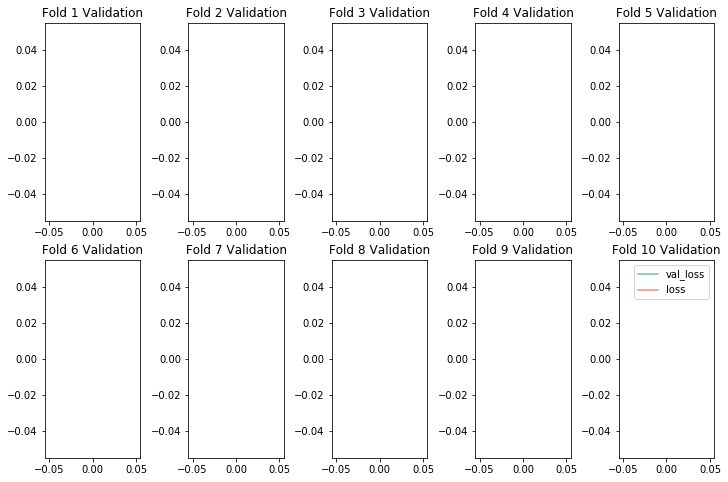

In [13]:
# Model Mod 3: More Layers, More Epochs 
# Timing Notes: On a top of the line mac-book pro, using our 10 fold cross validation methodology,
# a 5-layer neural network with 10 units per hidden layer and 250 epochs took ~45 minutes to train and validate

now = datetime.datetime.now()

input_dim = X_train_all.shape[1]

model = Sequential()
model.add(Dense(7, input_dim=input_dim, kernel_initializer='normal', activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, kernel_initializer='normal', activation = 'linear'))
model.compile(optimizer="sgd" ,loss='mse',metrics=['mse'])

k_folds(X_train_all, y_train, model, n_epochs=250)

later = datetime.datetime.now()
elapsed = later - now
print('Time Elapsed:', elapsed)

3190/3190 [==============================] - 0s 75us/step
Mean Validation Score: nan
Standard Deviation of Validation Scores: nan
Time Elapsed: 1:15:43.180279


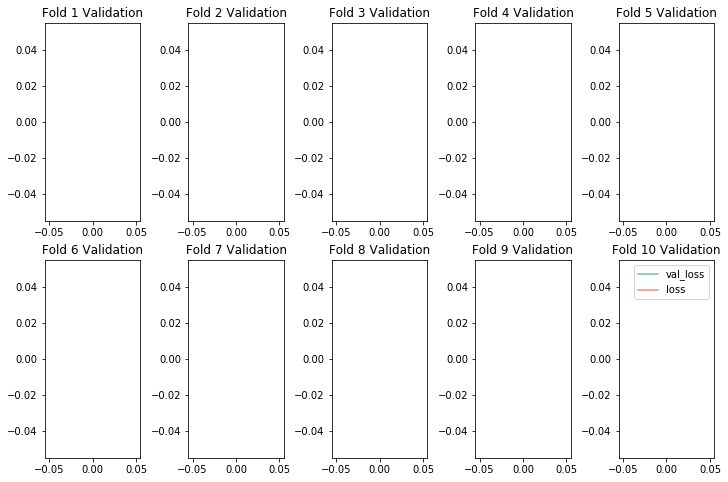

In [15]:
# L1 Regularization
from keras import regularizers

#kernel_regularizer=regularizers.l1(0.005)
#kernel_regularizer=regularizers.l2(0.005)
#model.add(layers.Dropout(0.3))

now = datetime.datetime.now()

input_dim = X_train_all.shape[1]

model = Sequential()
model.add(Dense(7, input_dim=input_dim, kernel_initializer='normal', activation='relu'))
model.add(Dense(10, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
model.add(Dense(10, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
model.add(Dense(10, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
model.add(Dense(1, kernel_initializer='normal', activation = 'linear'))
model.compile(optimizer="sgd" ,loss='mse',metrics=['mse'])

k_folds(X_train_all, y_train, model, n_epochs=250) 

later = datetime.datetime.now()
elapsed = later - now
print('Time Elapsed:', elapsed)

3190/3190 [==============================] - 0s 74us/step
Mean Validation Score: nan
Standard Deviation of Validation Scores: nan
Time Elapsed: 0:22:02.647927


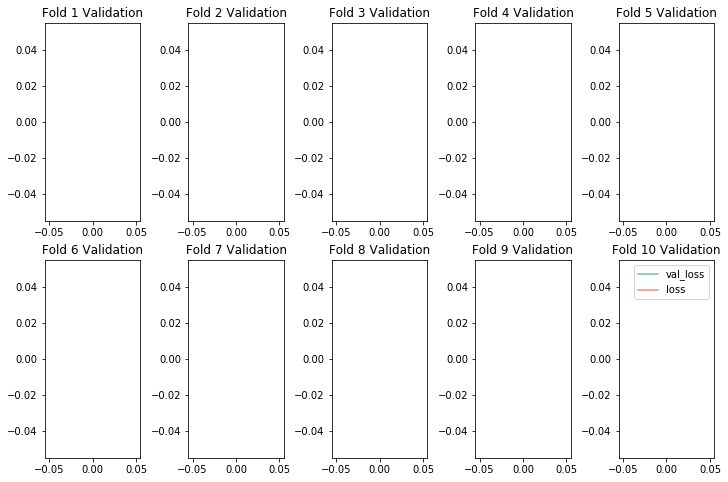

In [16]:
# L2 Regularization and Early Stopping
now = datetime.datetime.now()

input_dim = X_train_all.shape[1]

model = Sequential()
model.add(Dense(7, input_dim=input_dim, kernel_initializer='normal', activation='relu'))
model.add(Dense(10, kernel_regularizer=regularizers.l2(0.005), activation='relu'))
model.add(Dense(10, kernel_regularizer=regularizers.l2(0.005), activation='relu'))
model.add(Dense(10, kernel_regularizer=regularizers.l2(0.005), activation='relu'))
model.add(Dense(1, kernel_initializer='normal', activation = 'linear'))
model.compile(optimizer="sgd" ,loss='mse',metrics=['mse'])

k_folds(X_train_all, y_train, model, n_epochs=75) 

later = datetime.datetime.now()
elapsed = later - now
print('Time Elapsed:', elapsed)

3190/3190 [==============================] - 0s 95us/step
Mean Validation Score: nan
Standard Deviation of Validation Scores: nan
Time Elapsed: 0:25:17.078502


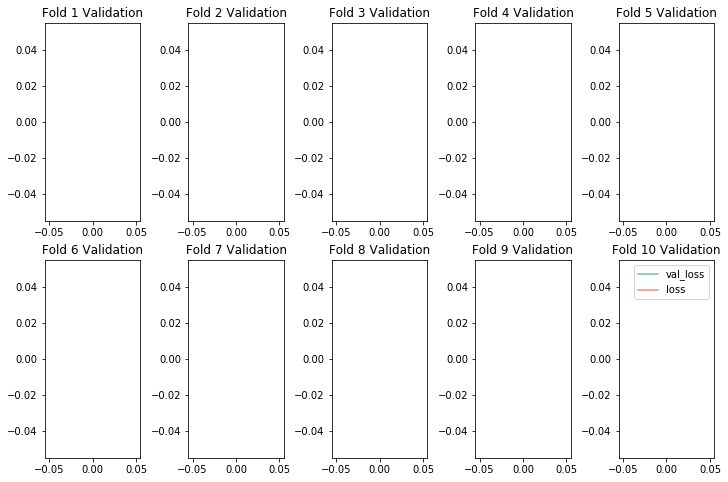

In [17]:
# Dropout and Early Stopping
from keras import layers

now = datetime.datetime.now()

input_dim = X_train_all.shape[1]

model = Sequential()
model.add(Dense(7, input_dim=input_dim, kernel_initializer='normal', activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(Dense(10, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(Dense(10, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(Dense(1, kernel_initializer='normal', activation = 'linear'))
model.compile(optimizer="sgd" ,loss='mse',metrics=['mse'])

k_folds(X_train_all, y_train, model, n_epochs=75) 

later = datetime.datetime.now()
elapsed = later - now
print('Time Elapsed:', elapsed)

3190/3190 [==============================] - 0s 81us/step
Mean Validation Score: nan
Standard Deviation of Validation Scores: nan
Time Elapsed: 0:25:05.870714


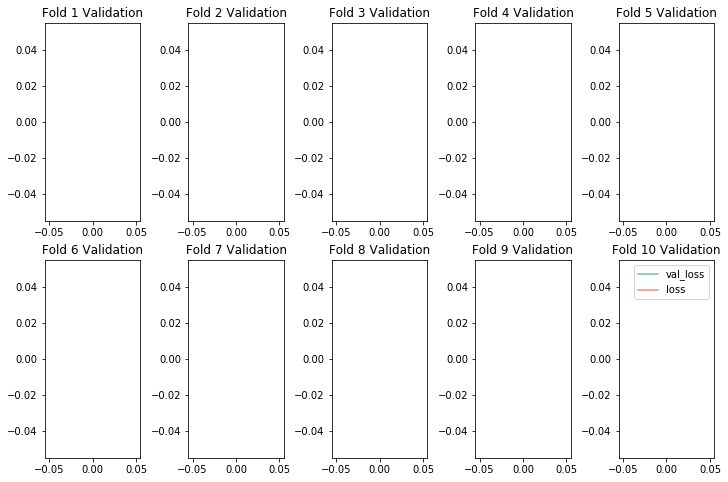

In [18]:
# L1, Dropout and Early Stopping

now = datetime.datetime.now()

input_dim = X_train_all.shape[1]

model = Sequential()
model.add(Dense(7, input_dim=input_dim, kernel_initializer='normal', activation='relu'))
model.add(Dense(10, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
model.add(layers.Dropout(0.3))
model.add(Dense(10, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
model.add(layers.Dropout(0.3))
model.add(Dense(10, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
model.add(layers.Dropout(0.3))
model.add(Dense(1, kernel_initializer='normal', activation = 'linear'))
model.compile(optimizer="sgd" ,loss='mse',metrics=['mse'])

k_folds(X_train_all, y_train, model, n_epochs=75) 

later = datetime.datetime.now()
elapsed = later - now
print('Time Elapsed:', elapsed)

In [19]:
# Your code here; final model training on entire training set followed by evaluation on hold-out data

# Based on our model runs above, it appears that using  L2 Regularization and Early Stopping
# improves our variance 10 fold in exchange for a slight increase in MSE
# As such, we will choose this as our final model in hopes that the model will have improved generalization
now = datetime.datetime.now()

input_dim = X_train_all.shape[1]

model = Sequential()
model.add(Dense(7, input_dim=input_dim, kernel_initializer='normal', activation='relu'))
model.add(Dense(10, kernel_regularizer=regularizers.l2(0.005), activation='relu'))
model.add(Dense(10, kernel_regularizer=regularizers.l2(0.005), activation='relu'))
model.add(Dense(10, kernel_regularizer=regularizers.l2(0.005), activation='relu'))
model.add(Dense(1, kernel_initializer='normal', activation = 'linear'))
model.compile(optimizer="sgd" ,loss='mse',metrics=['mse'])

hist =  hist = model.fit(X_train_all, y_train, batch_size=32, epochs=75)

later = datetime.datetime.now()
elapsed = later - now
print('Time Elapsed:', elapsed)

Epoch 1/75
31901/31901 [==============================] - 4s 120us/step - loss: nan - mse: nan
Epoch 2/75
31901/31901 [==============================] - 4s 130us/step - loss: nan - mse: nan
Epoch 3/75
31901/31901 [==============================] - 4s 119us/step - loss: nan - mse: nan
Epoch 4/75
31901/31901 [==============================] - 3s 90us/step - loss: nan - mse: nan
Epoch 5/75
31901/31901 [==============================] - 3s 93us/step - loss: nan - mse: nan
Epoch 6/75
31901/31901 [==============================] - 3s 92us/step - loss: nan - mse: nan
Epoch 7/75
31901/31901 [==============================] - 4s 134us/step - loss: nan - mse: nan
Epoch 8/75
31901/31901 [==============================] - 3s 104us/step - loss: nan - mse: nan
Epoch 9/75
31901/31901 [==============================] - 3s 100us/step - loss: nan - mse: nan
Epoch 10/75
31901/31901 [==============================] - 3s 94us/step - loss: nan - mse: nan
Epoch 11/75
31901/31901 [============================

In [20]:
model.evaluate(X_test_all, y_test)

10634/10634 [==============================] - 1s 120us/step


[nan, nan]